In [121]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import make_scorer

# Set randomizer seed
np.random.seed(0)

In [105]:
## Prepare data for model fitting

# Train and test sets on local machines
file_paths = ['~/datasets/bike/train.csv', '~/datasets/bike/test.csv']

# Define function to clean train and test data
def clean_data(path):
    """
    Input: path of csv files (train or test)
    Output: dataframe with features deleted and added
    """
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    # Split datetime up into 3 components (year, dayofyear, hour)
    df.insert(0, "year", df.index.year)
    df.insert(1, "month", df.index.month)
    df.insert(2, "dayofyear", df.index.dayofyear)
    df.insert(3, "hour", df.index.hour)    
    df.insert(4, "dayofweek", df.index.dayofweek)
    df.insert(5, "day", df.index.day)    
    # Fill in missing values in humidity and windspeed
    df.loc[df["humidity"]==0, "humidity"] = np.nan
    df.loc[df["windspeed"]==0, "windspeed"] = np.nan    
    # Fill forward first, then, backwards (for first few missing values)
    df = df.fillna(method="ffill").fillna(method="bfill")
    # Features addition
    # Commute: account for spike in demand around commute hours
    commute_hours = [7,8,9,16,17,18,19]
    df.insert(7, "commute", ((df["workingday"]==1) & (df["hour"].isin(commute_hours))).astype(int))
    # Features removal (season and temp)
    df = df.drop(['season', 'temp', 'windspeed'], axis=1)    
    return df

# Clean train and test csv files
df_train = clean_data(file_paths[0])
df_test = clean_data(file_paths[1])

In [3]:
# Print options
pd.set_option('display.max_rows', 999)

In [138]:
## Time Series Analysis
# Join train and test data and column orders
df_all = pd.concat([df_train, df_test])

# Restore original columns
df_all = df_all[df_train.columns]
# Sort on index
df_all = df_all.sort()

# Introduce lagged atemp variables (1hr, 2hr, 3hr, 4hr, 5hr) (Didn't improve accuracy)
#atemp_lagvars = ['atemp_lag'+str(k)+'h' for k in range(1,6)]
#for j in range(5):
#    df_all[atemp_lagvars[j]] = df_all['atemp'].shift(j+1)

# Introduce monthly demand variable from train data, and merge back into df_all dataframe
index = df_all.index
df_monthly_count = df_train.resample('M', how='mean')[["year", "month", "count"]]
df_monthly_count.columns.values[2] = "monthly_count"
df_all = pd.merge(df_all, df_monthly_count)
df_all.index = index

# Rearrange columns & fill na's
old_cols = df_train.columns.tolist()
new_cols = old_cols[:-3] + ["monthly_count"] + old_cols[-3:]
df_all = df_all[new_cols]

# Split into train and test again
df_train = df_all.loc[df_train.index]
df_test = df_all.ix[df_test.index, :-3]

In [107]:
# Get train feature names (excluding outcomes variables: casual, registered, count)
print ("Feature names: ")
print (df_train.columns.values[:-3])
# Print out first 5 training examples with outcome variables
print ("\nFirst 10 examples: ")
print (df_train.head(10))

# Extract numerical features 
X, Y = df_train.iloc[:, :-3].values, df_train.iloc[:, -3:].values
test_data = df_test.values
# Split all training data into train set and dev set (dev consists of 15% of train)
train_data, dev_data, train_labels, dev_labels = train_test_split(X, Y, test_size=0.15, random_state=0)

# Array sizes
print ("\nTrain data: {}".format(train_data.shape))
print ("Dev data: {}".format(dev_data.shape))
print ("Test data: {}".format(test_data.shape))
print ("Train labels: {}".format(train_labels.shape))

Feature names: 
['year' 'month' 'dayofyear' 'hour' 'dayofweek' 'day' 'commute' 'holiday'
 'workingday' 'weather' 'atemp' 'humidity' 'monthly_count']

First 10 examples: 
                     year  month  dayofyear  hour  dayofweek  day  commute  \
datetime                                                                     
2011-01-01 00:00:00  2011      1          1     0          5    1        0   
2011-01-01 01:00:00  2011      1          1     1          5    1        0   
2011-01-01 02:00:00  2011      1          1     2          5    1        0   
2011-01-01 03:00:00  2011      1          1     3          5    1        0   
2011-01-01 04:00:00  2011      1          1     4          5    1        0   
2011-01-01 05:00:00  2011      1          1     5          5    1        0   
2011-01-01 06:00:00  2011      1          1     6          5    1        0   
2011-01-01 07:00:00  2011      1          1     7          5    1        0   
2011-01-01 08:00:00  2011      1          1     8 

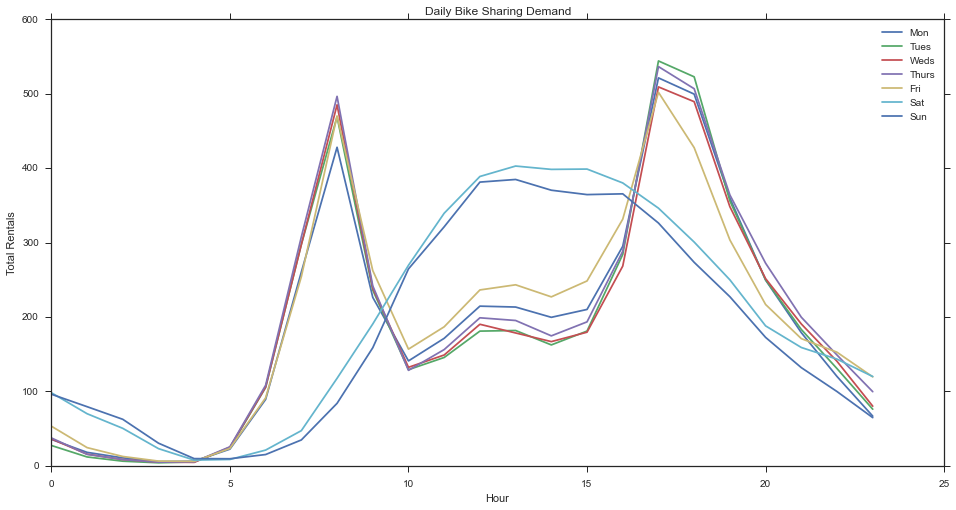

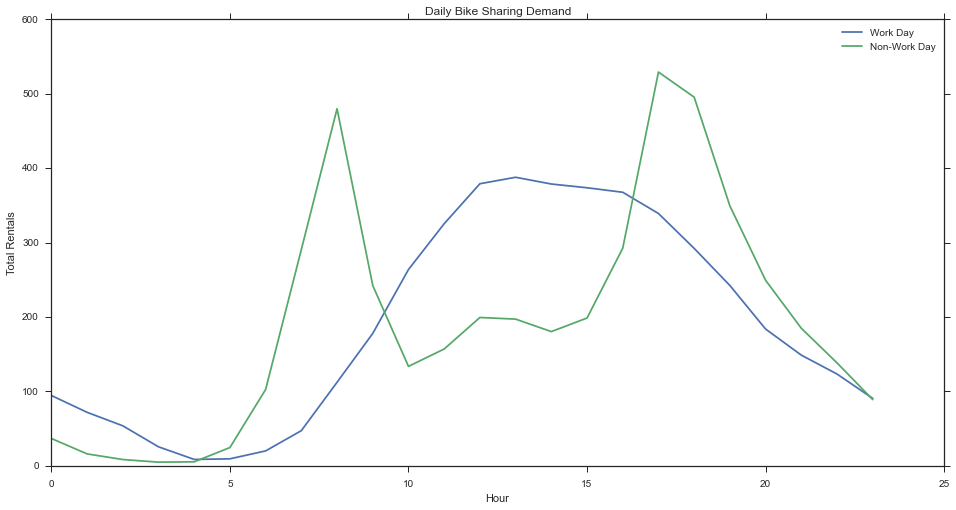

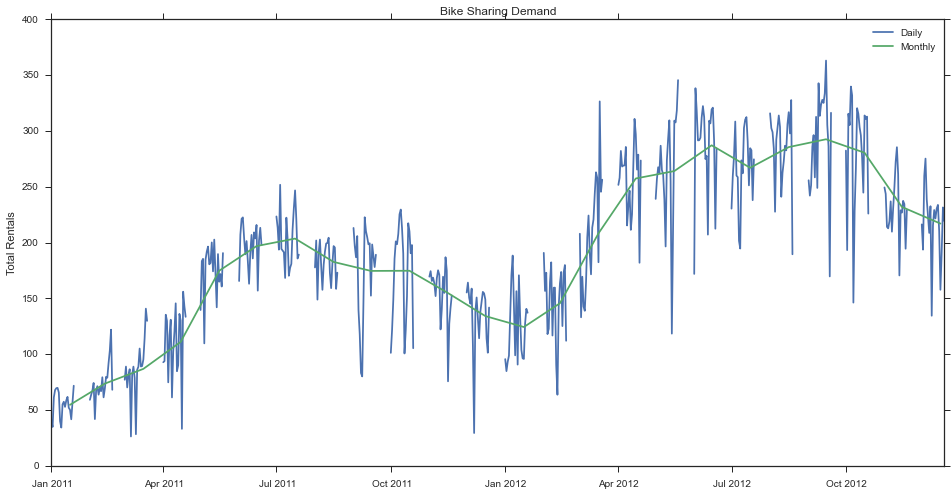

In [122]:
# Keep for plotting purposes
sns.set_style("ticks")

# Trends for demand daily for working day and non working day
df_hourly_dayofweek = df_train.groupby(["dayofweek", "hour"]).mean()
day_labels = ["Mon", "Tues", "Weds", "Thurs", "Fri", "Sat", "Sun"]
plt.figure(figsize = (16,8))
for d in range(7):
    plt.plot(df_hourly_dayofweek.ix[d].index, df_hourly_dayofweek.ix[d]['count'], label=day_labels[d])
title = plt.title('Daily Bike Sharing Demand')
xlabel = plt.xlabel('Hour')
ylabel = plt.ylabel('Total Rentals')
legend = plt.legend(frameon=False)

# Trends for demand daily for working day and non working day
df_hourly = df_train.groupby(["workingday", "hour"]).mean()
plt.figure(figsize = (16,8))
workplot = plt.plot(df_hourly.ix[0].index, df_hourly.ix[0]['count'], label="Work Day")
nonworkplot = plt.plot(df_hourly.ix[1].index, df_hourly.ix[1]['count'], label="Non-Work Day")
title = plt.title('Daily Bike Sharing Demand')
xlabel = plt.xlabel('Hour')
ylabel = plt.ylabel('Total Rentals')
legend = plt.legend(frameon=False)

# Trends for demand over time
# Aggregate by day and by month
df_dailymean = df_train.resample('D', how='mean')
df_monthlymean = df_train.resample('M', how='mean')
# Plot time series
plt.figure(figsize = (16,8))
dailyplot = plt.plot(df_dailymean.index, df_dailymean['count'], label="Daily")
monthlyplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_monthlymean['count'], label="Monthly")
title = plt.title('Bike Sharing Demand')
ylabel = plt.ylabel('Total Rentals')
legend = plt.legend(frameon=False)

In [ ]:
# Histograms for cetain variables
plt.figure(figsize=(10,10))
plt.subplot(321)
df_train["weather"].hist()
plt.subplot(322)
df_train["temp"].hist(bins=20)
plt.subplot(323)
df_train["humidity"].hist(bins=20) # missing values
plt.subplot(324)
df_train["windspeed"].hist(bins=20) # missing values
plt.subplot(325)
df_train["count"].hist(bins=20)

In [8]:
# Evaluation: Root Mean Squared Logarithmic Error (RMSLE)
def RMSLE(actual, predicted):
    """
    Inputs: actual counts, predicted counts
    Outputs: Root Mean Squared Logarithmic Error
    """
    return np.sqrt(np.mean(np.square(np.log(predicted+1) - np.log(actual+1))))

# Make a scoring object for GridSearch to use
RMSLE_scorer = make_scorer(RMSLE, greater_is_better=False)

In [108]:
## Feature Scaling
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
dev_data_scaled = scaler.transform(dev_data)

In [137]:
# Linear Regression with L2 Regularization
# Fit ridge regression model
lr_ridge_model = Ridge(alpha=2400)
lr_ridge_model.fit(train_data, train_labels)
preds = lr_ridge_model.predict(dev_data)

# Predictions cannot be negative, convert negative predictions to zero
preds[preds<0] = 0
print ("RMSLE: {}".format(RMSLE(dev_labels, preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, preds)))

RMSLE: 1.19854235299
R-square on dev: 0.525420581396


In [136]:
## kNN Regression
k = 3
knn_model = KNeighborsRegressor(n_neighbors = k, weights = "distance")
knn_model.fit(train_data_scaled, train_labels)
knn_preds = knn_model.predict(dev_data_scaled)

# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels, knn_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, knn_preds)))

RMSLE: 0.685850545948
R-square on dev: 0.746129179644


RMSLE: 0.400035541219
R-square on dev: 0.905563415927
[ 0.     0.001  0.006  0.529  0.005  0.003  0.147  0.     0.034  0.011
  0.036  0.023  0.205]


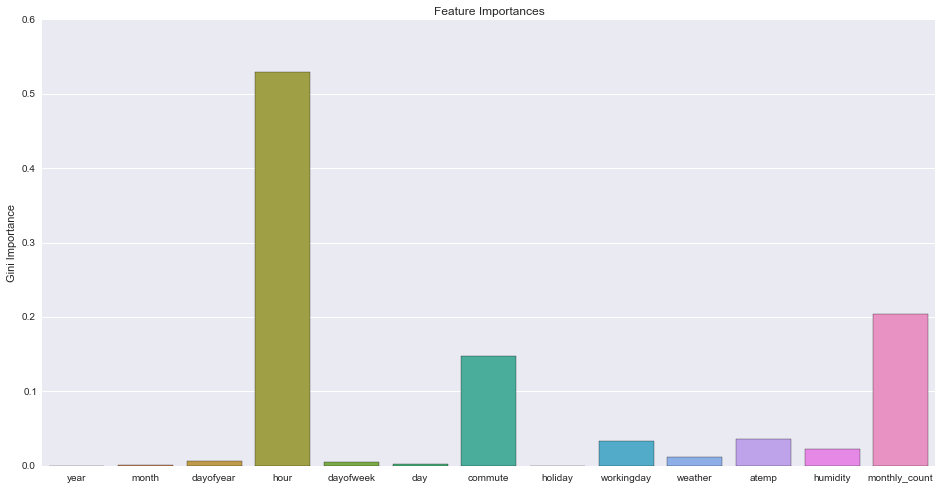

In [123]:
## Decision Trees
# Ensure consistency of results
np.random.seed(0)

# Fit decision tree regressor
dt_model = DecisionTreeRegressor(max_depth=9)
dt_model.fit(train_data_scaled, train_labels[:, 2])
dt_preds = dt_model.predict(dev_data_scaled)

# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 2], dt_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 2], dt_preds)))
print (np.round(dt_model.feature_importances_,3))

# Keep for plotting purposes
sns.set_style("darkgrid")
# Plot feature importances
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=dt_model.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")

In [ ]:
# Decision Tree Grid Search
dt_params = {"max_depth": np.arange(1,30)}
dt_grid = GridSearchCV(DecisionTreeRegressor(), dt_params, scoring=RMSLE_scorer)
dt_grid.fit(train_data_scaled, train_labels)

print (dt_grid.best_score_)
print (dt_grid.best_params_)

RMSLE: 0.334136489964
R-square on dev: 0.956779599772
[ 0.024  0.007  0.032  0.424  0.02   0.01   0.184  0.002  0.029  0.014
  0.071  0.045  0.138]


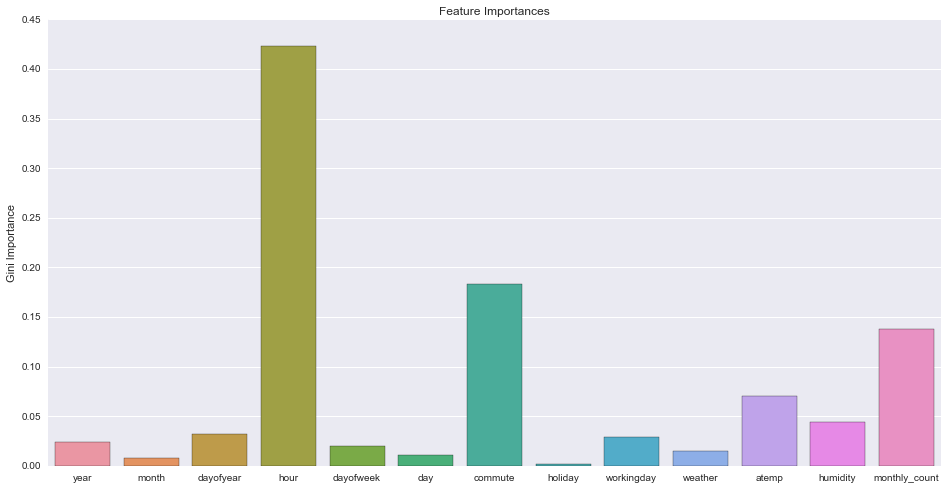

In [124]:
## Random Forest Regressor
# Ensure consistency of results
np.random.seed(0)

# Fit random forest regressor
rf_model = RandomForestRegressor(n_estimators = 100, max_features = 8)
rf_model.fit(train_data_scaled, train_labels[:, 2])
rf_preds = rf_model.predict(dev_data_scaled)

# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 2], rf_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 2], rf_preds)))
print (np.round(rf_model.feature_importances_,3))

# Plot feature importances
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=rf_model.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")

In [ ]:
# Random Forest Grid Search
# Ensure consistency of results
np.random.seed(0)
rf_params = {"n_estimators": np.arange(1,101)}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, scoring=RMSLE_scorer)
rf_grid.fit(train_data_scaled, train_labels)

print (rf_grid.best_score_)
print (rf_grid.best_params_)

In [ ]:
# Random forest plot
accuracies = [-rf_grid.grid_scores_[i][1] for i in range(40)]
plt.figure(figsize=(16,8))
scatter = plt.plot(rf_params["n_estimators"], accuracies, 'bo')
title = plt.title ("Random Forest (m=8)")
xlabel = plt.xlabel ("Number of Estimators")
ylabel = plt.ylabel ("RMSLE")
# Looks maxed out around n=30

In [111]:
## Adaboost with Decision Tree Regressor
# Ensure consistency of results
np.random.seed(0)

# Fit Adaboost with decision tree regressor
ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20), n_estimators=30)
ada_model.fit(train_data_scaled, train_labels[:, 2])
ada_preds = ada_model.predict(dev_data_scaled)

# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 2], ada_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 2], ada_preds)))
print (np.round(ada_model.feature_importances_,3))

RMSLE: 0.331067491592
R-square on dev: 0.94886033789
[ 0.001  0.004  0.029  0.315  0.023  0.019  0.206  0.002  0.042  0.034
  0.058  0.072  0.194]


In [112]:
## Predict both "causal" and "registered" users with different models (Adaboost)

# Casual users: random forest
# Ensure consistency of results
np.random.seed(0)
# Fit random forest regressor
ada_casual = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20), n_estimators=30)
ada_casual.fit(train_data_scaled, train_labels[:, 0])
ada_casual_preds = ada_casual.predict(dev_data_scaled)
# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 0], ada_casual_preds)))
# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 0], ada_casual_preds)))
print (np.round(ada_casual.feature_importances_,3))

# Registered users: random forest
# Fit random forest regressor
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20), n_estimators=30)
ada_reg.fit(train_data_scaled, train_labels[:, 1])
ada_reg_preds = ada_reg.predict(dev_data_scaled)
# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 1], ada_reg_preds)))
# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 1], ada_reg_preds)))
print (np.round(ada_reg.feature_importances_,3))

# Add up casual + registered
ada_total_preds = ada_casual_preds + ada_reg_preds
# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 2], ada_total_preds)))
# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 2], ada_total_preds)))

RMSLE: 0.503885084392
R-square on dev: 0.927826932045
[ 0.003  0.007  0.043  0.273  0.03   0.03   0.003  0.004  0.192  0.007
  0.212  0.108  0.086]
RMSLE: 0.321914668905
R-square on dev: 0.949223897823
[ 0.001  0.006  0.024  0.242  0.022  0.019  0.345  0.003  0.01   0.052
  0.03   0.069  0.178]
RMSLE: 0.321633117363
R-square on dev: 0.952439003504


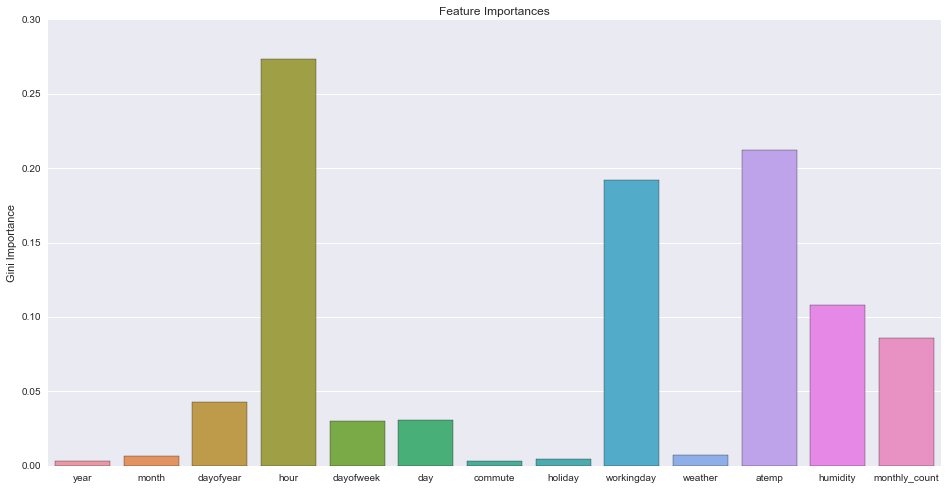

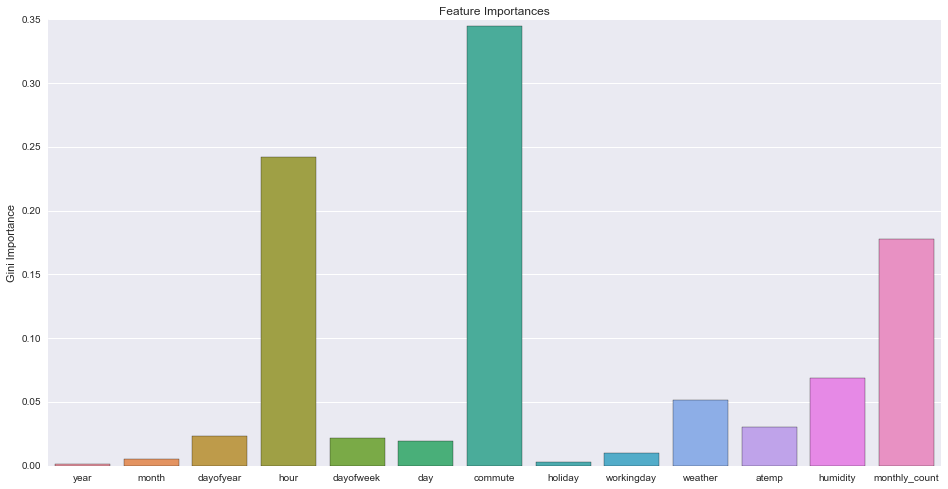

In [113]:
# Plot feature importances (casual)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=ada_casual.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")
# Plot feature importances (registered)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=ada_reg.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")

In [114]:
## Predict both "causal" and "registered" users with different models (Random Forest)

# Casual users: random forest
# Ensure consistency of results
np.random.seed(0)
# Fit random forest regressor
rf_casual = RandomForestRegressor(n_estimators = 100, max_features = 8)
rf_casual.fit(train_data_scaled, train_labels[:, 0])
rf_casual_preds = rf_casual.predict(dev_data_scaled)
# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 0], rf_casual_preds)))
# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 0], rf_casual_preds)))
print (np.round(rf_casual.feature_importances_,3))

# Registered users: random forest
# Fit random forest regressor
rf_reg = RandomForestRegressor(n_estimators = 100, max_features = 8)
rf_reg.fit(train_data_scaled, train_labels[:, 1])
rf_reg_preds = rf_reg.predict(dev_data_scaled)
# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 1], rf_reg_preds)))
# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 1], rf_reg_preds)))
print (np.round(rf_reg.feature_importances_,3))

# Add up casual + registered
rf_total_preds = rf_casual_preds + rf_reg_preds
# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels[:, 2], rf_total_preds)))
# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels[:, 2], rf_total_preds)))

RMSLE: 0.489482637754
R-square on dev: 0.942236280503
[ 0.01   0.011  0.035  0.325  0.077  0.021  0.005  0.004  0.108  0.008
  0.256  0.074  0.066]
RMSLE: 0.327444584561
R-square on dev: 0.95593355891
[ 0.034  0.008  0.035  0.318  0.014  0.009  0.362  0.002  0.01   0.016
  0.04   0.032  0.121]
RMSLE: 0.3280034204
R-square on dev: 0.957737136126


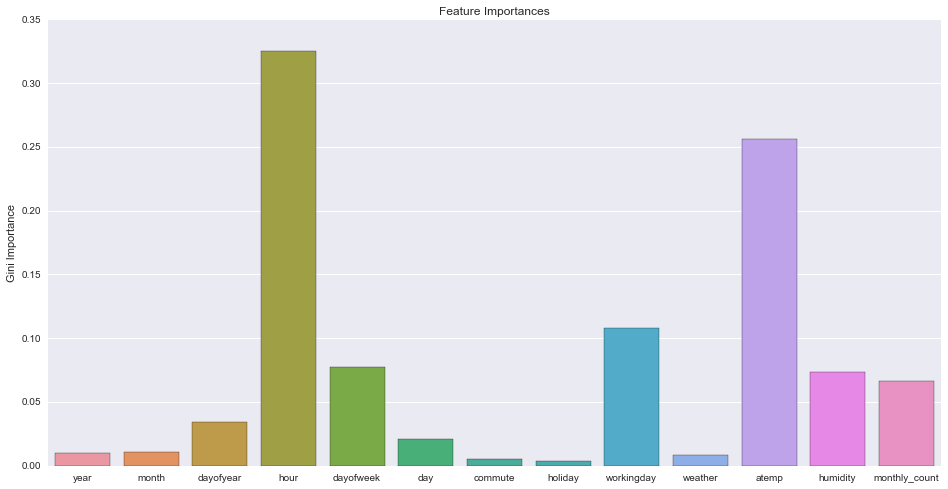

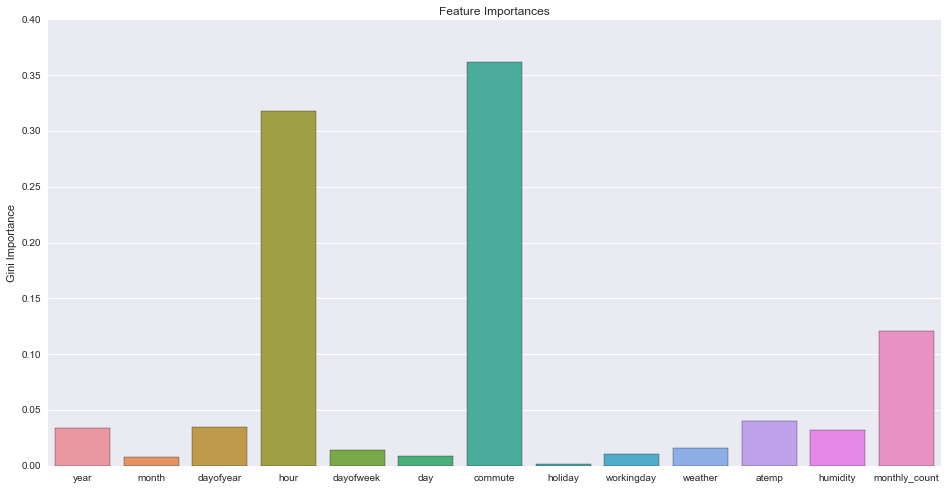

In [115]:
# Plot feature importances (casual)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=rf_casual.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")
# Plot feature importances (registered)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[:-3], y=rf_reg.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")

In [ ]:
# Error Analysis (to be done)
# Data and correct labels
# dev_data
# dev_labels

# Predictions
# rf_casual_preds
# rf_reg_preds
# rf_total_preds

In [97]:
## Write results in Kaggle format
# Scale ALL train and test data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_data_scaled = scaler.transform(test_data)

# Predict using Adaboost and Random Forest (RF: 0.49, ADA: 0.48, ADA_split: 0.47541, RF_split:0.47461)
rf_casual.fit(X_scaled, Y[:, 0])
rf_reg.fit(X_scaled, Y[:, 1])
kaggle_preds = rf_casual.predict(test_data_scaled) + rf_reg.predict(test_data_scaled)

# Write to csv
out_path = '/Users/InfernoIX/datasets/bike/kaggle_submission.csv'
df_submission = pd.DataFrame({"datetime": df_test.index, "count": kaggle_preds}, columns = ["datetime", "count"])
df_submission.to_csv(out_path, index=False)